In [1]:
import os
import tempfile
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi
import seaborn as sns
import torch

from _quasiSCVI import QuasiSCVI
from _quasivae import QuasiVAE


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.3


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Here we use the pancreas dataset described in the [scIB](https://github.com/theislab/scib) manuscript, that is also widely used to benchmark integration methods.

In [4]:
pancreas_adata_path = "/Users/ismail/thesis/Human Pancreas Normal.h5ad"

pancreas_adata = sc.read(
    pancreas_adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539828",
)
pancreas_adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

We consider the SS2 and CelSeq2 samples as query, and all the others as reference.

In [5]:
query_mask = np.array([s in ["smartseq2", "celseq2"] for s in pancreas_adata.obs["tech"]])

pancreas_ref = pancreas_adata[~query_mask].copy()
pancreas_query = pancreas_adata[query_mask].copy()

We run highly variable gene selection on the reference data and use these same genes for the query data.

In [6]:
sc.pp.highly_variable_genes(pancreas_ref, n_top_genes=2000, batch_key="tech", subset=True)

pancreas_query = pancreas_query[:, pancreas_ref.var_names].copy()

In [7]:
#### Quasi Likelihood Model

In [8]:
QuasiSCVI.setup_anndata(pancreas_ref, batch_key="tech", layer="counts")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [9]:
pancreas_adata.obs["tech"].unique()

['celseq', 'celseq2', 'fluidigmc1', 'smartseq2', 'inDrop1', 'inDrop2', 'inDrop3', 'inDrop4', 'smarter']
Categories (9, object): ['celseq', 'celseq2', 'fluidigmc1', 'inDrop1', ..., 'inDrop3', 'inDrop4', 'smarter', 'smartseq2']

We train the reference using the standard SCVI workflow, except we add a few non-default parameters that were identified to work well with scArches.

In [10]:
# Initialize the Quasi SCVI model
scvi_ref = QuasiSCVI(
    pancreas_ref,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

# Train the model
scvi_ref.train(max_epochs=400, plan_kwargs={"lr": 1e-4})

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|███████████████████████████████████| 400/400 [06:31<00:00,  1.02it/s, v_num=1, train_loss_step=7.92e+4, train_loss_epoch=2.05e+5]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████| 400/400 [06:31<00:00,  1.02it/s, v_num=1, train_loss_step=7.92e+4, train_loss_epoch=2.05e+5]


In [11]:
scvi_ref.history["elbo_train"]
train_loss = scvi_ref.history["elbo_train"]
kl_divergence = scvi_ref.history["kl_local_train"]

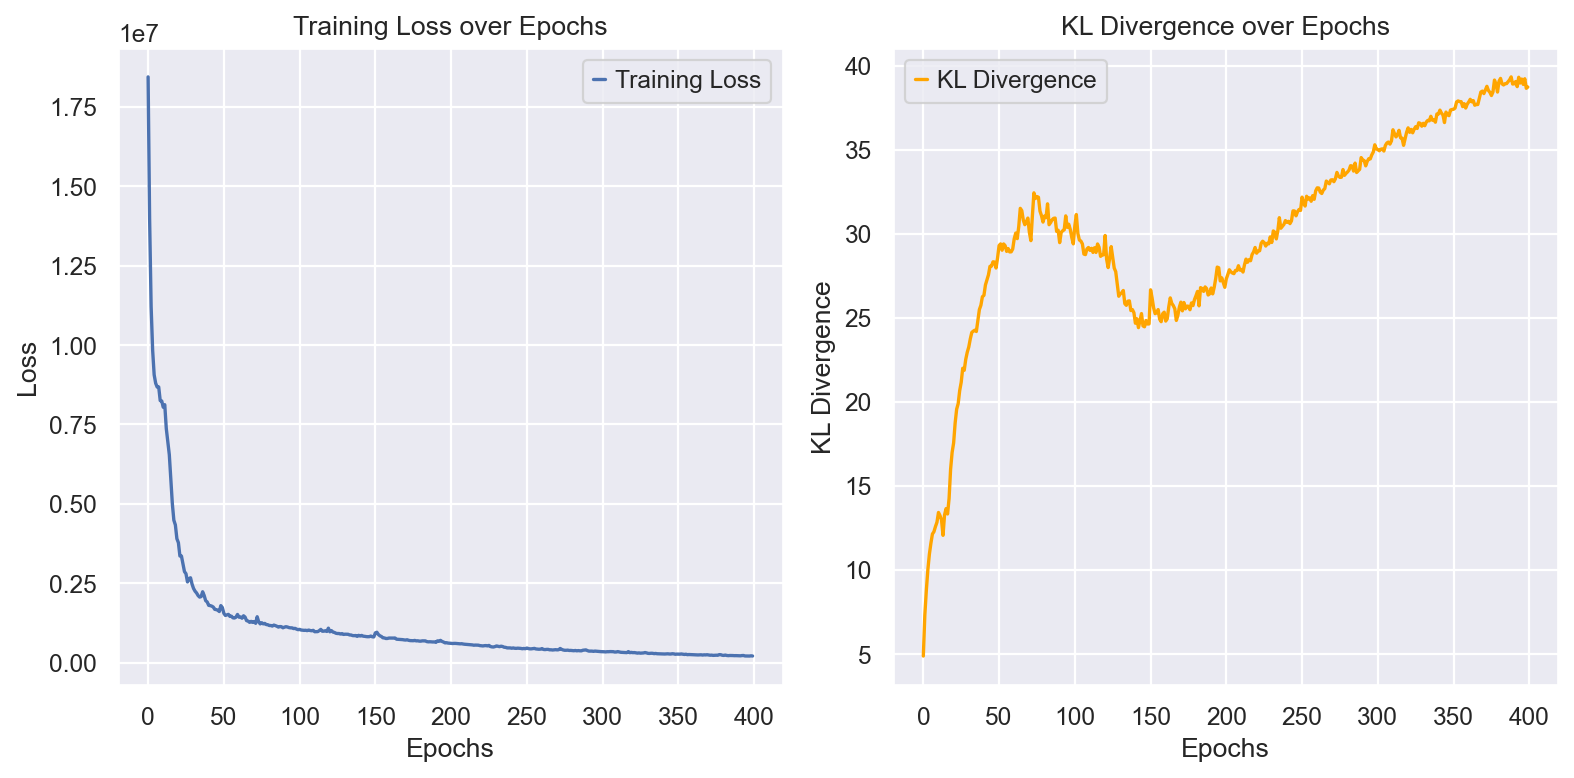

In [12]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot KL divergence
plt.subplot(1, 2, 2)
plt.plot(kl_divergence, label='KL Divergence', color='orange')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Now we obtain the latent representation, and use Scanpy to visualize with UMAP.

In [13]:
SCVI_LATENT_KEY = "X_scVI"

pancreas_ref.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
sc.pp.neighbors(pancreas_ref, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(pancreas_ref)
sc.tl.umap(pancreas_ref)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/3k/yfw07yqn6nbdwjkxhf022b2m0000gn/T/ipykernel_87829/205088744.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(pancreas_ref)


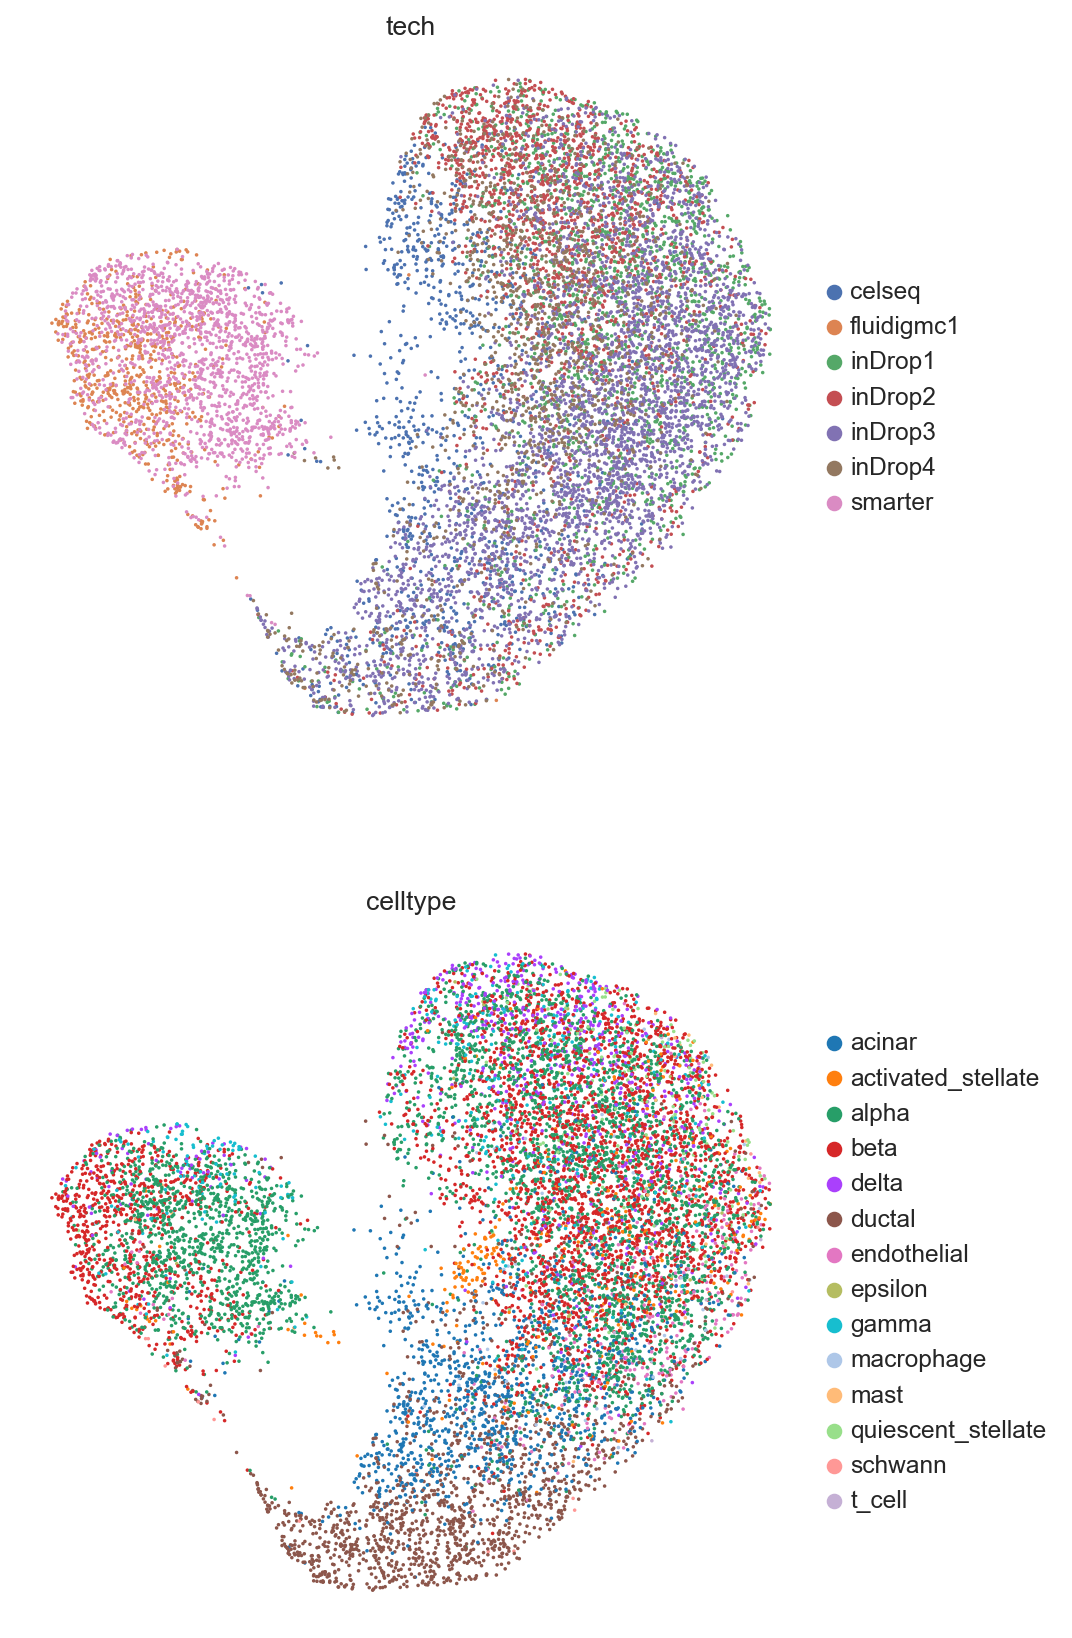

In [14]:
sc.pl.umap(
    pancreas_ref,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)